In [51]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_colwidth', 50)

import nltk
from nltk import word_tokenize

# get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
import re # for cleaning textual data (uses regular expressions ouch!)
from collections import Counter # for counting tokens occurences
import math # for calculations

import nltk
from nltk.tokenize import word_tokenize # for tokenization
from nltk.corpus import stopwords
from nltk.probability import FreqDist # for overall tokens frequency
from nltk.tokenize import RegexpTokenizer 

import gensim
from gensim import corpora # for: Dictionary(), word2bow()
from gensim import models # for: TfidfModel()

from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer

from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM
from sklearn.decomposition import TruncatedSVD # this performs LSA!
from sklearn.decomposition import NMF # this performs NMF (or NNMF if you prefer)
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import statistics # for: quantiles()
import time # for measuring time of computation
from collections import defaultdict # we will need it to easily track the number of unique tokens in corpus
import math

from bertopic import BERTopic
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('MachineLearning_reddit.csv')

In [3]:
df.head()

,title,score,id,subreddit,url,num_comments,body,created,timestamp
0,[D] Simple Questions Thread,14,qorekl,MachineLearning,https://www.reddit.com/r/MachineLearning/comme...,54,Please post your questions here instead of cre...,1.636301e+09,2021-11-07 17:00:18
1,[P][R] Rocket-recycling with Reinforcement Lea...,607,qt2tws,MachineLearning,https://v.redd.it/enkc1p6oldz71,33,NaN,1.636815e+09,2021-11-13 15:52:07
2,[Project] PyTorch Implementations of 37 GAN pa...,334,qt10az,MachineLearning,https://i.redd.it/fjf94vuj4dz71.png,22,NaN,1.636809e+09,2021-11-13 14:13:18
3,[P] Using Talknet to clone Dreams' voice.,70,qt9yql,MachineLearning,https://v.redd.it/hmw9gpizefz71,19,NaN,1.636837e+09,2021-11-13 21:56:42
4,[R] StyleGAN of All Trades: Image Manipulation...,699,qsw47b,MachineLearning,https://i.redd.it/arv5dyfjfbz71.jpg,12,NaN,1.636789e+09,2021-11-13 08:31:19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         469 non-null    object 
 1   score         469 non-null    int64  
 2   id            469 non-null    object 
 3   subreddit     469 non-null    object 
 4   url           469 non-null    object 
 5   num_comments  469 non-null    int64  
 6   body          387 non-null    object 
 7   created       469 non-null    float64
 8   timestamp     469 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 33.1+ KB


In [5]:
df.dropna(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 466
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         387 non-null    object 
 1   score         387 non-null    int64  
 2   id            387 non-null    object 
 3   subreddit     387 non-null    object 
 4   url           387 non-null    object 
 5   num_comments  387 non-null    int64  
 6   body          387 non-null    object 
 7   created       387 non-null    float64
 8   timestamp     387 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 30.2+ KB


In [7]:
df.describe()

,score,num_comments,created
count,387.000000,387.000000,3.870000e+02
mean,33.932817,12.524548,1.635758e+09
std,79.166714,24.979397,6.806483e+05
min,0.000000,0.000000,1.634506e+09
25%,1.000000,1.000000,1.635216e+09
50%,5.000000,4.000000,1.635779e+09
75%,23.000000,10.000000,1.636386e+09
max,662.000000,211.000000,1.636879e+09


In [8]:
df.shape

(387, 9)

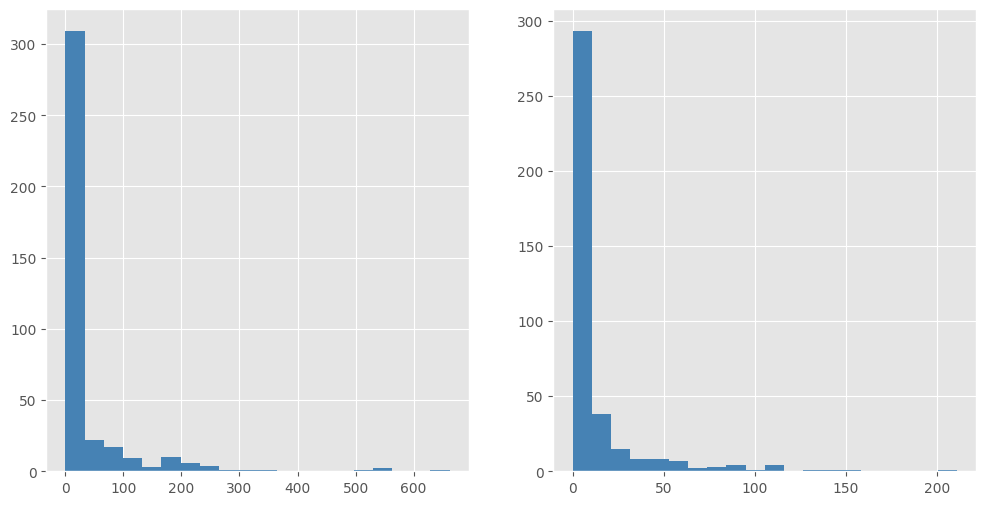

In [9]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)

plt.hist(df['score'], bins = 20, color = 'steelblue')

plt.subplot(1,2,2)

plt.hist(df['num_comments'], bins = 20, color = 'steelblue')
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


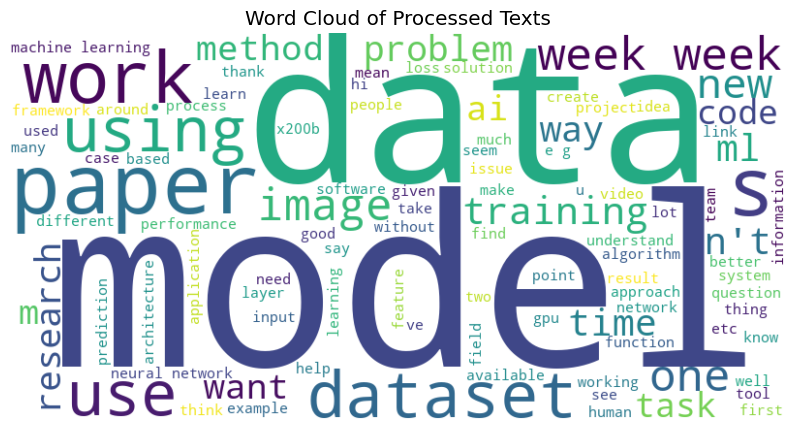

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stop_words.add

def preprocess_text(text):
    # Check if the value is a string
    if isinstance(text, str):
        pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        
        # Apply regex to remove links
        text = re.sub(pattern, '', text)
        
        # Tokenization
        tokens = word_tokenize(text.lower())  # Convert to lowercase during tokenization
        
        # Remove punctuation
        tokens = [word for word in tokens if word not in string.punctuation]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Join tokens back to a single string
        processed_text = ' '.join(tokens)
        
        return processed_text
    else:
        return str(text)  # Convert non-string values to string

processed_texts = df['body'].apply(lambda x: preprocess_text(x))

# Join all processed texts into a single string
all_text = ' '.join(processed_texts)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Texts')
plt.show()


### HANDLE Contractions ### !!!!!!


Mean Squared Error: 20.278929604331584


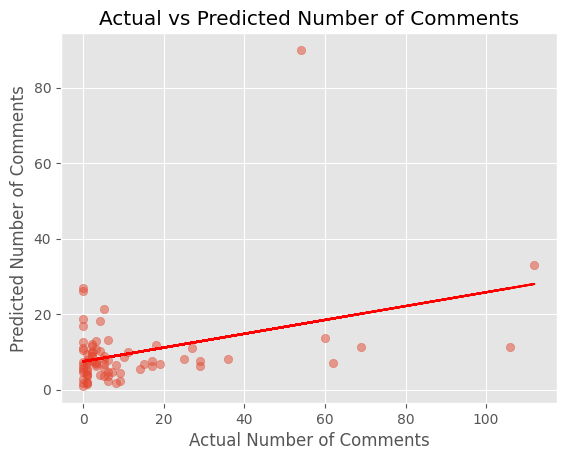

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_texts)

# Target variable
y = df['num_comments']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model (using Mean Squared Error as an example)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", np.sqrt(mse))

# Create a scatter plot comparing actual vs predicted values
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Actual Number of Comments')
plt.ylabel('Predicted Number of Comments')
plt.title('Actual vs Predicted Number of Comments')

# Add a trendline (optional)
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red')

plt.show()



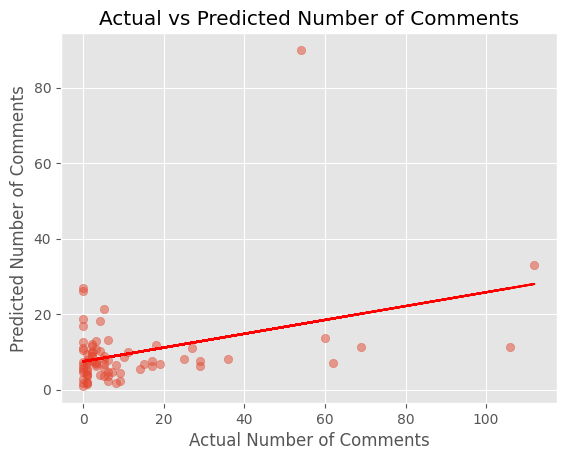

In [12]:
# Create a scatter plot comparing actual vs predicted values
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Actual Number of Comments')
plt.ylabel('Predicted Number of Comments')
plt.title('Actual vs Predicted Number of Comments')

# Add a trendline (optional)
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red')

plt.show()


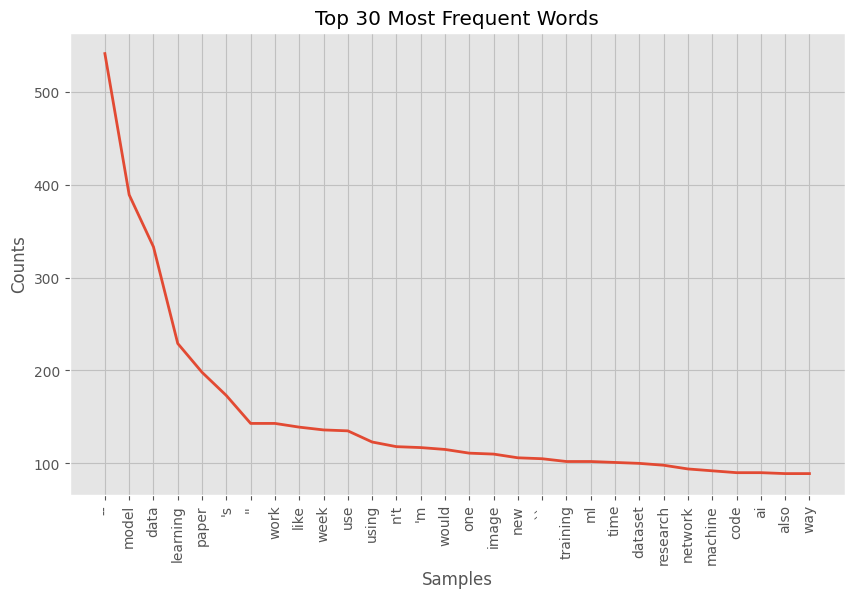

<AxesSubplot: title={'center': 'Top 30 Most Frequent Words'}, xlabel='Samples', ylabel='Counts'>

In [13]:
from nltk.probability import FreqDist

# Join all processed texts into a single string
all_text = ' '.join(processed_texts)

# Generate a frequency distribution
tokens = all_text.split()
freq_dist = FreqDist(tokens)

# common_words = freq_dist.most_common(20)
# print(common_words)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.title('Top 30 Most Frequent Words')
freq_dist.plot(30, cumulative=False)

In [18]:

df['subreddit'] = df['subreddit']

df = df[['subreddit','body' ]]
df.head()



,sentiment,subreddit,body
0,neutral,MachineLearning,Please post your questions here instead of cre...
6,neutral,MachineLearning,Hi!\r\n\r\nI am working on a time series probl...
7,neutral,MachineLearning,"Hello All,\r\n\r\nI have updated my ongoing Da..."
9,neutral,MachineLearning,We analysed the relationship between ICLR 2022...
10,neutral,MachineLearning,I created this demo in two days (last weekend)...


In [19]:


#filtering dataset for United
df = df[df['subreddit']=='MachineLearning'] 
print(len(df))
df = df.reset_index(drop = True)
df.head(10)



387


,sentiment,subreddit,body
0,neutral,MachineLearning,Please post your questions here instead of cre...
1,neutral,MachineLearning,Hi!\r\n\r\nI am working on a time series probl...
2,neutral,MachineLearning,"Hello All,\r\n\r\nI have updated my ongoing Da..."
3,neutral,MachineLearning,We analysed the relationship between ICLR 2022...
4,neutral,MachineLearning,I created this demo in two days (last weekend)...
5,neutral,MachineLearning,I will soon be building a deep learning machin...
6,neutral,MachineLearning,**Video**\r\n\r\n[https://youtu.be/LKixq2S2Pz...
7,neutral,MachineLearning,Generally any application software co-exists w...
8,neutral,MachineLearning,A recent paper [On Buggy Resizing Libraries an...
9,neutral,MachineLearning,Are you looking for a time series feature extr...


In [21]:


# move to sentiment analysis
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)  #call the polarity analyzer
    print("{:-<40} {}".format(sentence, str(snt)))



In [22]:


# compound value scale = -1 to 1 (-ve to +ve)
print_sentiment_scores("United flight was a bad experience")



United flight was a bad experience------ {'neg': 0.376, 'neu': 0.323, 'pos': 0.301, 'compound': -0.1779}


In [23]:


get_ipython().run_line_magic('time', '# to calulate the time it takes the algorithm to compute a VADER score')
i=0 # counter

compval1 = [ ] # empty list to hold our computed 'compound' VADER scores

while (i<len(df)):

    k = analyser.polarity_scores(str(df.iloc[i]['body']))
    compval1.append(k['compound'])
    
    i = i+1
    
# convert sentiment values to numpy for easier usage
compval1 = np.array(compval1)
len(compval1)



CPU times: total: 0 ns
Wall time: 0 ns


387

In [24]:


df['VADER score'] = compval1



In [25]:


get_ipython().run_line_magic('time', '')

# assign score categories and logic
i = 0

predicted_value = [ ] # empty series to hold our predicted values

while(i<len(df)):
    if ((df.iloc[i]['VADER score'] >= 0.7)):
        predicted_value.append('positive')
        i = i+1
    elif ((df.iloc[i]['VADER score'] > 0) & (df.iloc[i]['VADER score'] < 0.7)):
        predicted_value.append('neutral')
        i = i+1
    elif ((df.iloc[i]['VADER score'] <= 0)):
        predicted_value.append('negative')
        i = i+1



CPU times: total: 0 ns
Wall time: 0 ns


In [26]:


df['predicted sentiment'] = predicted_value



<AxesSubplot: xlabel='predicted sentiment'>

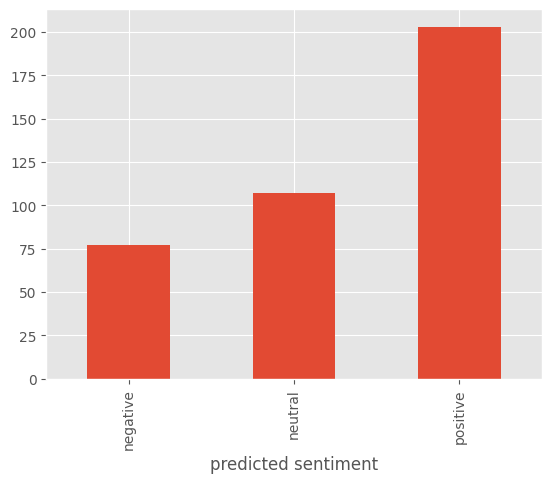

In [29]:


df.groupby('predicted sentiment').size().plot(kind='bar')



In [30]:

# some basic visualization
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 

df_neg = df[df['predicted sentiment']=='negative']

words = ' '.join(df['body'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

stopwords = set(STOPWORDS)
# stopwords.add("amp")
# stopwords.add("flight")
# stopwords.add("united")
# stopwords.add("plane")
# stopwords.add("now")

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)



In [39]:


df_neg = df[df['predicted sentiment']=='negative']

words = ' '.join(df['body'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

stopwords = list(STOPWORDS)
stopwords.append("model")
stopwords.append("learning")
stopwords.append("training")
stopwords.append("data")
stopwords.append("paper")
stopwords.append("image")
stopwords.append("problem")
stopwords.append("machine")
stopwords += ['patient','use', 'using', 'reddit', 'https', 'www', 'make', 'know', 'new', 'one']

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

In [32]:
type(cleaned_word)

str

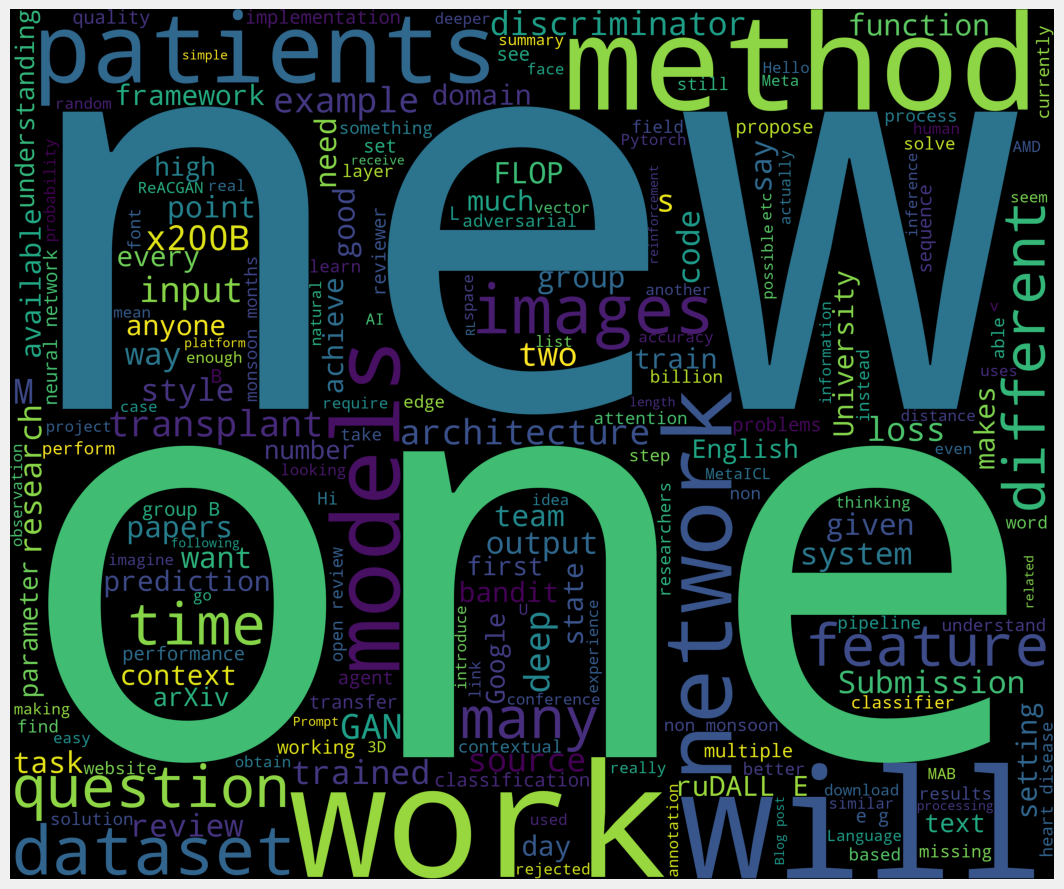

In [40]:

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [41]:
tokenizer = RegexpTokenizer(r'\w+') # tokenizer
stop_words = nltk.corpus.stopwords.words('english')
stopwords.append('oh')
stop_words.append('use')
stop_words.append('using')
stopwords.append('are')

# more about CountVectorizer(): https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#examples-using-sklearn-feature-extraction-text-countvectorizer
tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tfidf_vectorizer = TfidfVectorizer(encoding = 'utf-8', # if bytes to analyze, this encoding will be used
                                   decode_error = 'strict', # if we want to get an error in case of encoding error
                                   strip_accents = None, # if we want to do something we accents
                                   
                                   lowercase = True, # all letters to lower case 
                                   stop_words = stopwords, # what stopwords do we want to use 
                                   ngram_range = (1, 3), # what kind of ngrams do we want 
                                   
                                   max_df = 0.8, # filtering with document frequency
                                   min_df = 2, # filtering with document frequency
                                   max_features = None, # if we want to use only the tokens with top document frequency
                                   
                                   tokenizer = tokenizer.tokenize # tokenizer
)

tfidf = tfidf_vectorizer.fit_transform(df['body']) # using raw data for now
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out() # feature names

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [35]:
def plot_top_words(model, feature_names, n_top_words, title = '', subplotx = 2, subploty = 5):
    fig, axes = plt.subplots(subplotx, subploty, figsize=(60, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=30)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=1.5, bottom=0.05, wspace=2.5, hspace=0.3)
    plt.show()

In [62]:


tf = tfidf_vectorizer.fit_transform(df['body'])
tf_feature_names = tfidf_vectorizer.get_feature_names_out()

lsa = TruncatedSVD(n_components = 16, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index)+": ",top_terms_list)



Topic 0:  ['png', 'arxiv', 'arxiv org', 'org', 'abs', 'arxiv org abs', 'org abs', 's', 'gan', 'auto webp']
Topic 1:  ['png', 'auto webp', 'auto webp s', 'format', 'preview', 'preview redd', 'redd', 'webp', 'webp s', 'width']
Topic 2:  ['m', 't', 'b', 'different', 'loss', '1', 'will', 'models', 'given', 'good']
Topic 3:  ['ru', 'en', 'rudall', 'rudall e', 'sberbank', 'e', 'translate', 'company sberbank', 'company sberbank blog', 'habr']
Topic 4:  ['style', '3d', 'high', 'networks', 'encoder', 'performance', 'architectures', 'aware', 'based', 'low']
Topic 5:  ['gan', 't', 'arxiv', 'casual', 'casual_gan', 'casualganpapers', 't casual_gan', 'discriminator', 'twitter', 'style transfer']
Topic 6:  ['models', 'source', 'code', 'open', 'anyone', 'question', 'author', 'see', 'version', 'inference']
Topic 7:  ['many', 'question', 'papers', 'makes', 'system', 'see', 'provide', 'currently', 'see many', 'still']
Topic 8:  ['images', '3d', 'b', 'quality', 'e', 'openreview', 'annotation', 'e g', 'g',

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [61]:
lda = LatentDirichletAllocation(n_components = 16, 
                   random_state = 42)

model = lda.fit_transform(tf)

for index, component in enumerate(lda.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index)+": ",top_terms_list)



Topic 0:  ['papers', 'provide', 'amd', 'status', 'twitter', 'arxiv', 'many', 's', 'day', 'allows']
Topic 1:  ['e', 'ru', 'gan', 'deep', 'good', 'will', 'networks', 't', 'need', 'e g']
Topic 2:  ['models', 'flops', 'system', 'much', 'billion', 'transformer', 'compute', 'due', 'limit', 'link']
Topic 3:  ['etc', 'datasets', 'style', 'transfer', 'method', 'style transfer', 'states', 'human', 'trying', 'idea']
Topic 4:  ['models', 'inference', 'choose', 'guys', 'gpu', 'made', 'specific', 'run', 'pipeline', 'multiple']
Topic 5:  ['per', 'links', 'layers', 'number', 'minimum', '7', '20', 'min', 'x200b x200b', 'gap']
Topic 6:  ['discriminator', 'l', 'tensorflow', 'title', 'perform', 'classifier', 'actually', 'feature', 'fake', 'regression']
Topic 7:  ['3d', 'classification', 'research', 'ai', 'thinking', 'space', 'annotation', '08', '11 08', '2021 11 08']
Topic 8:  ['papers', 'output', 'length', 'sequence', 'word', 'iclr', 'review', '0', 'concern', 'l']
Topic 9:  ['mlops', 'rudall', 'rudall e'

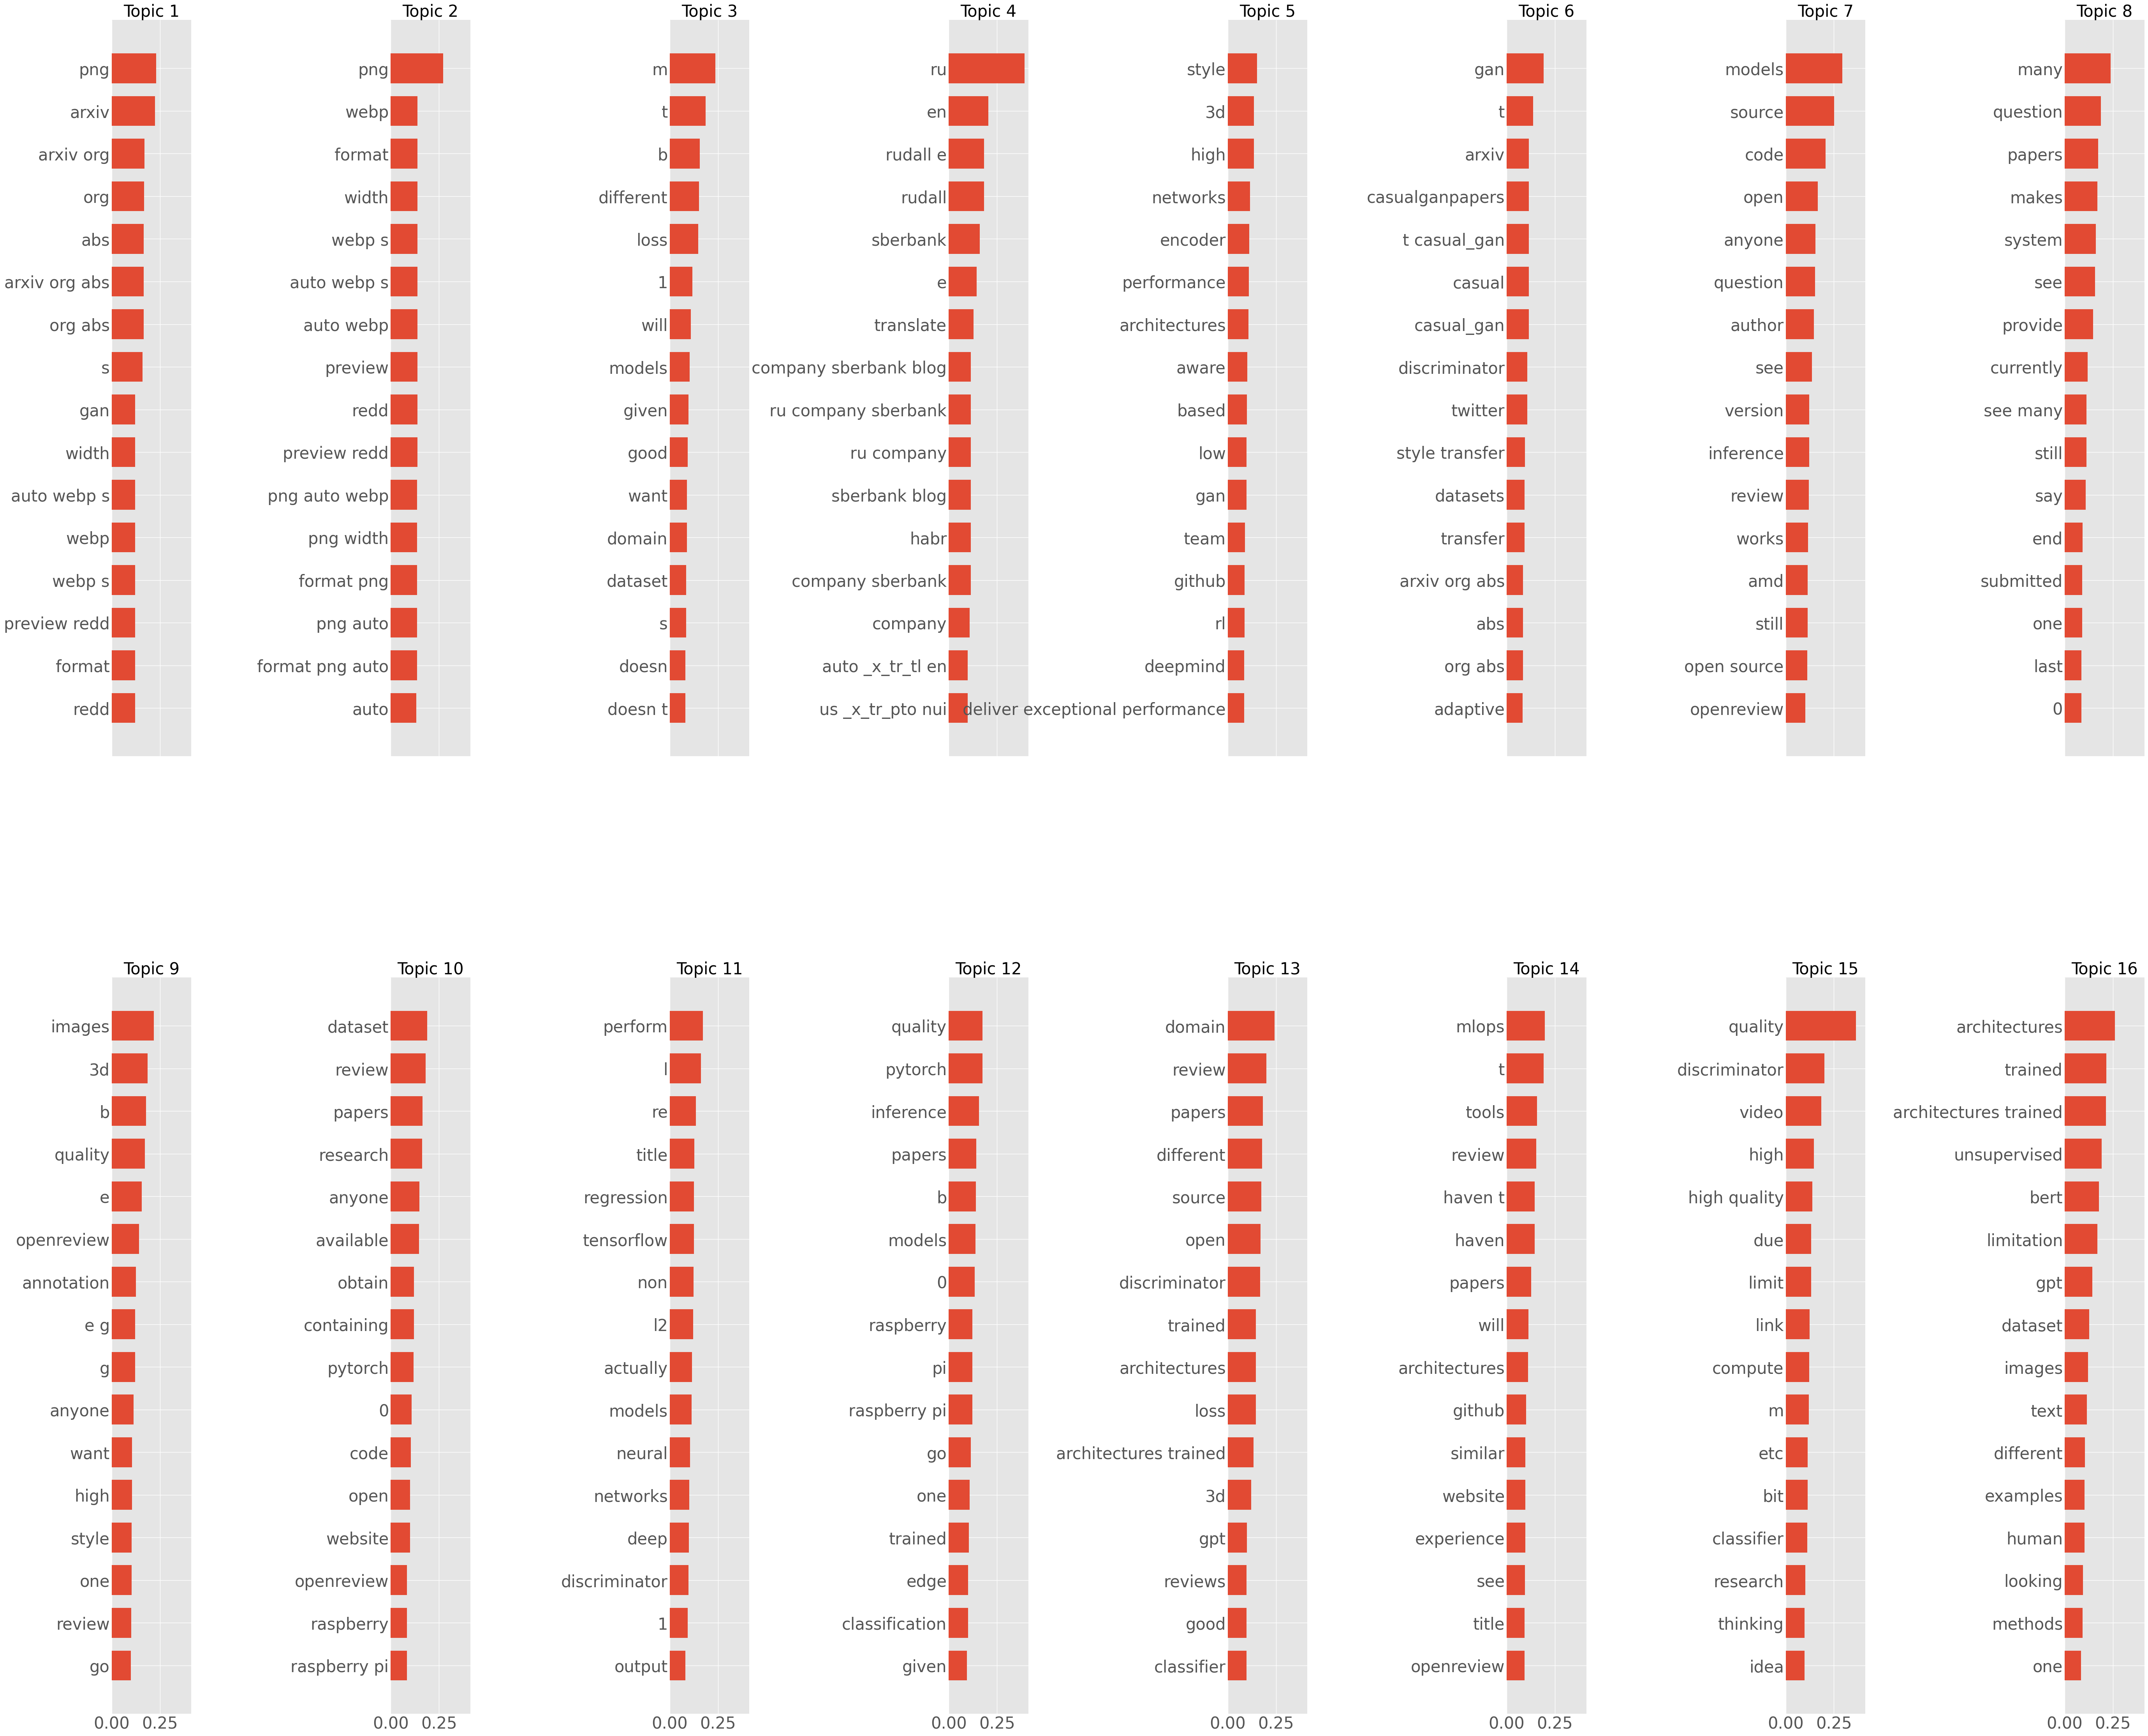

In [63]:
plot_top_words(lsa, tf_feature_names, 16, title = '', subplotx = 2, subploty = 8)

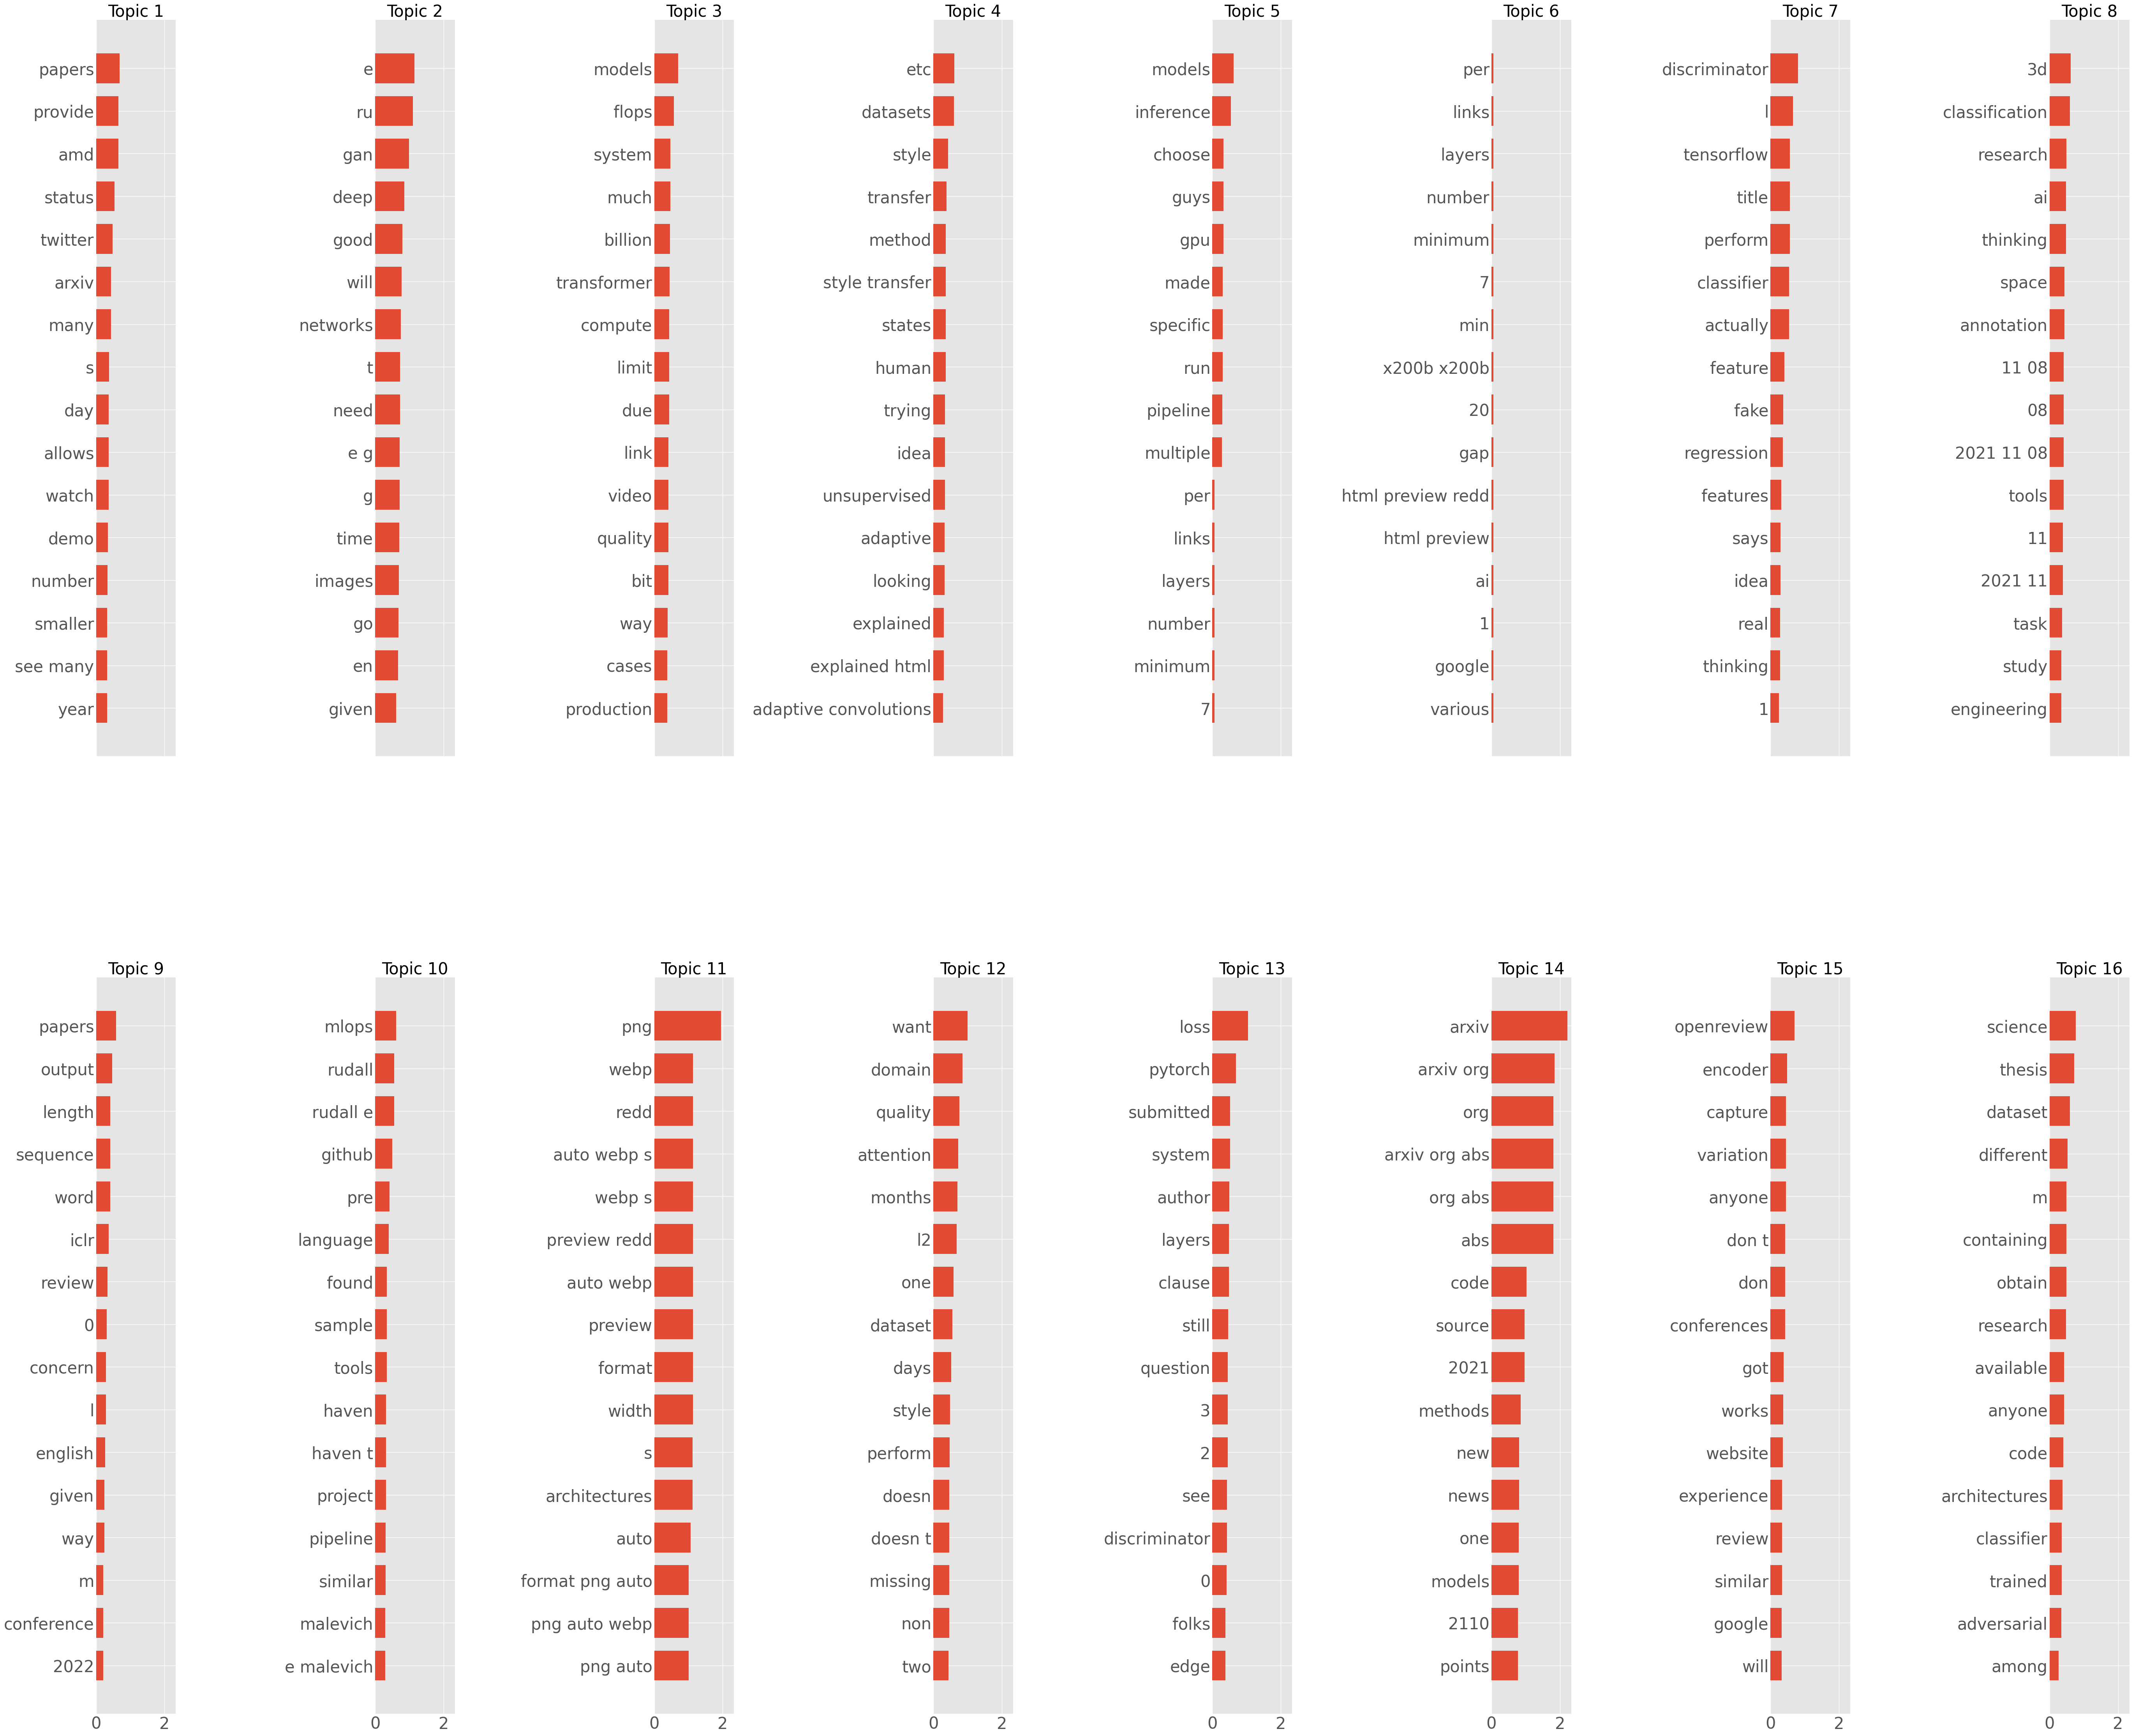

In [64]:
plot_top_words(lda, tf_feature_names, 16, title = '', subplotx = 2, subploty = 8)

In [66]:
from sklearn.decomposition import NMF
import random

f_feature_names = tfidf_vectorizer.get_feature_names_out()

nmf = NMF(n_components=5, random_state=42)
nmf.fit(tf)



for i in range(5):
    random_id = random.randint(0,len(f_feature_names))
    print(f_feature_names[random_id])

first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-5:]


for i in top_topic_words:
    print(tfidf_vectorizer.get_feature_names_out()[i])


for i,topic in enumerate(nmf.components_):
    print(f'Top five words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]])
    print('\n')


download file
available project s
especially
title
tasks
auto webp s
webp
auto webp
webp s
png
Top five words for topic #0:
['auto webp s', 'webp', 'auto webp', 'webp s', 'png']


Top five words for topic #1:
['arxiv org', 'org abs', 'arxiv org abs', 'abs', 'arxiv']


Top five words for topic #2:
['loss', 'different', 'b', 't', 'm']


Top five words for topic #3:
['sberbank', 'rudall', 'rudall e', 'en', 'ru']


Top five words for topic #4:
['deep', '3d', 'performance', 'high', 'networks']




In [70]:


# add a column to the original data frame that will store the topic for the text
topic_values = lda.transform(tf)
topic_values.shape




# add a new column for topic in the data frame and assigns the topic value to each row in the column
df['Topic_LDA'] = topic_values.argmax(axis=1)


topic_values = lsa.transform(tf)
topic_values.shape
# add a new column for topic in the data frame and assigns the topic value to each row in the column
df['Topic_LSA'] = topic_values.argmax(axis=1)

df.head()



C:\Users\HP\AppData\Local\Temp\ipykernel_2292\3247664181.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Topic_LDA'] = topic_values.argmax(axis=1)
C:\Users\HP\AppData\Local\Temp\ipykernel_2292\3247664181.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Topic_LSA'] = topic_values.argmax(axis=1)


(array([18.,  7.,  7.,  3., 12.,  5.,  6.,  4.,  6.,  9.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

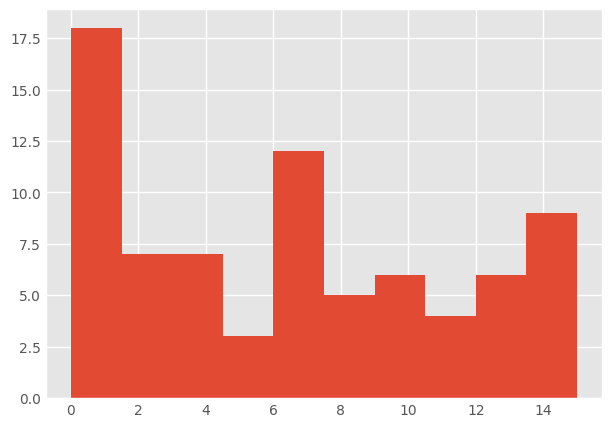

In [72]:
plt.hist(df['Topic_LSA'])

(array([17.,  4.,  3.,  0.,  7.,  2., 12.,  7., 20.,  5.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

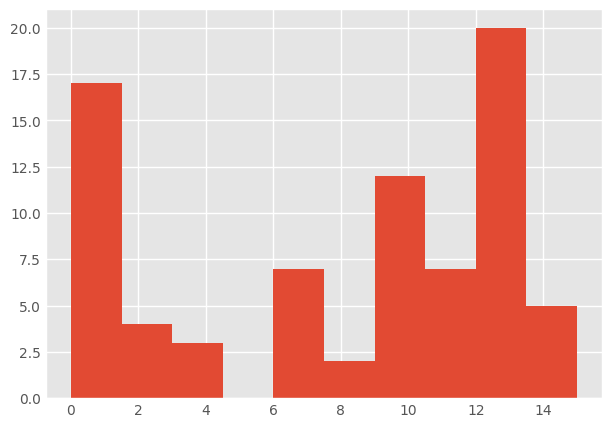

In [73]:
plt.hist(df['Topic_LDA'])

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25


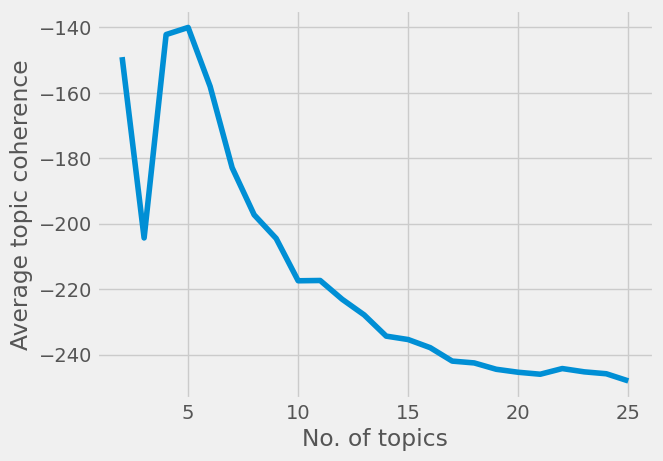

In [45]:
tf = tfidf_vectorizer.fit_transform(df['body'])
f_feature_names = tfidf_vectorizer.get_feature_names_out()

topic_coherence_specific = []

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

for n_topics in range(2,26,1):
    
    print('Trying parameters:', n_topics)
    
    lsa = TruncatedSVD(n_components = n_topics, n_iter = 25, random_state = 42) 
    #less iterations used above to not wait till tomorrow, results will be less precise though
                
    lsa.fit_transform(tf)
                
    avg_coherence = get_average_topic_coherence(tf, lsa.components_, 25)
    
    topic_coherence_specific.append([avg_coherence, n_topics])
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_df = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

save_object(topic_coherence_specific_df, 'outputs/topic_coherence_lsa_countvectotizer.pkl')
with open("outputs/topic_coherence_lsa_countvectotizer.pkl", "rb") as fp:
    topic_coherence_specific_df = pickle.load(fp)
plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df['n_topics'],topic_coherence_specific_df['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

## BERTopic

In [ ]:
lemmatized_stop_words = set([lemmatizer.lemmatize(word) for word in stop_words])
lemmatizer = WordNetLemmatizer()


def generate_ngrams(text, ngram = 1):
    temp = zip(*[text[i:] for i in range(0,ngram)]) # set with pairs, three, ..., ns of tokens
    ans = [' '.join(ngram) for ngram in temp] # joins the elements in strings
    ans = pd.Series(ans).map(lambda x: re.sub(" ", '_', x)) # replaces spaces with '_'
    return list(ans)

def remove_stopwords(lists):
    return [word for word in lists if word not in lemmatized_stop_words]

comments_cleaned = [remove_stopwords(comment) for comment in df['body']]

comments_cleaned


for i in range(0,len(comments_cleaned)):
    unigrams = comments_cleaned[i]
    bigrams = generate_ngrams(comments_cleaned[i], ngram = 2)
    trigrams = generate_ngrams(comments_cleaned[i], ngram = 3)
    
    text = []
    text.append(unigrams)
    text.append(bigrams)
    text.append(trigrams)
    
    comments_cleaned[i] = [item for sublist in text for item in sublist] 


In [ ]:
comments_joined = [' '.join(com) for com in comments_cleaned]

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, min_topic_size = 2, nr_topics = 5)
topics, probs = topic_model.fit_transform(df['body'])

bert_document_info = pd.DataFrame(topic_model.get_document_info(df['body']))

In [ ]:
print(set(topics))

topic_info = topic_model.get_topic_info()
# print(topic_info)
topic_info


In [ ]:
try:
    topic_model.visualize_topics()
except Exception as e:
    print(f"An error occurred during visualization: {e}")

topic_model.visualize_topics()

In [ ]:

for i in range(min(5, len(topic_model.get_topics()))):
    print(f"Topic {i}: {topic_model.get_topic(i)}")

In [ ]:
similarity_matrix = cosine_similarity(topic_model.topic_embeddings_)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
plt.title("Topic Similarity Heatmap")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


In [ ]:
try:
    topic_model.visualize_barchart()
except Exception as e:
    print(f"An error occurred during barchart visualization: {e}")

topic_model.visualize_barchart()

In [ ]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(lyrics) for lyrics in comments_joined]
df['sentiments_sia'] = sentiments


# Extracting compound scores and categorizing sentiments
df['compound'] = df['sentiments_sia'].apply(lambda x: x['compound'])
df['sentiment_category'] = df['compound'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
df['topic_bertopic'] = bert_document_info['Topic']